In [70]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [1]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
import scipy.io as spio
import numpy as np

In [2]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 18
rcParams['font.serif'] = ['Computer Modern Roman']
rcParams['text.usetex'] = True
rcParams["font.weight"] = "bold"
rcParams["axes.labelweight"] = "bold"

In [3]:
import netCDF4
ncdata = netCDF4.Dataset('nucl/lcn0_other.e')
ncdata.variables['name_nod_var'][0,:].data
b''.join(ncdata.variables['name_nod_var'][0,:].data)==b'eta'
#print(''.join(ncdata.variables['name_nod_var'][0,:].data))
#print(ncdata.variables['name_elem_var'][0,:])
#print(np.max(np.abs(ncdata.variables['vals_elem_var1eb1'][0,:])))

True

In [154]:
import netCDF4
ncdata = netCDF4.Dataset('nucl/lcn_Kp_p_1.0E+01_c_1.0E+00_other_alpha0.e')
print(ncdata.variables['name_elem_var'][4,:])
print(np.max(np.abs(ncdata.variables['vals_elem_var5eb1'][0,:])))
ncdata.variables['connect1'].shape
print(ncdata.variables['connect1'][200])
ncdata.variables['vals_elem_var1eb1'].shape
print(ncdata.variables['coordx'][404])
ncdata.variables['coordx'][ncdata.variables['connect1'][200]]
#''.join(ncdata.variables['name_nod_var'][2,:].data)

['c' 'u' 'r' 'r' 'd' 'e' 'n' 's' '' '\xe8' '\xa4' '\xdc' 'O' '\xb4' '\xd3'
 '-' '<' '\xe5' '\xba' '\xac' "'" '\xeb' 'D' '\xec' '\xbd' '\x85' '\xd0'
 '\xb8' '\x0f' '\x94' '\xb0' '\xc1' '\xbd']
0.8726012293237673
[  4   3 403 404]
2.0


array([2., 0., 0., 2.])

In [3]:
from __future__ import print_function
import netCDF4
import numpy as np
#import matplotlib.pyplot as plt                                                                                                                                                                                                                                                                                                                      
from glob import glob
import pickle
from scipy.integrate import trapz

class ExodusAnalyzer:
    def __init__(self, filename = None):
        self.filename = filename
        self.ncdata = netCDF4.Dataset(self.filename)

    def TimeTransf(self, tstart = 400, Xval = 150, numeta = 2):
        if b''.join(self.ncdata.variables['name_nod_var'][numeta,:].data) != b'eta':
                raise ValueError('The variable given by numeta is {}, not eta'.format( b''.join(self.ncdata.variables['name_nod_var'][numeta,:].data) ))
        etavarname = 'vals_nod_var'+str(numeta+1)
        eta_on_nodes = self.ncdata.variables[etavarname]
        nsteps = eta_on_nodes.shape[0]
        if(nsteps<tstart):
            print('No data for t>'+str(tstart))
            return -2.0, -2.0, -2.0
        #print('nsteps={}\n'.format(nsteps))
        X = self.ncdata.variables['coordx']
        Y = self.ncdata.variables['coordy']
        time_whole = self.ncdata.variables['time_whole'][:]
        eps = 1e-6
        for t in range(tstart, nsteps):
            #print('At tstep={}, time = {}'.format(t,time_whole[t]))                                                                                                                                                                                                                                                                                    
            line_inds = np.where(np.abs(X[:]-Xval) < eps)[0]
            if any(eta_on_nodes[t, line_inds]>0.5):
                #print('Phase transf at: {}'.format(t))
                #Calculating exact time assuming constant velocity                                                                                                                                                                                                                                                                                      
                inds = np.extract(eta_on_nodes[t, line_inds]>0.5,line_inds)
                t_exact_min = time_whole[-1]
                for ind in inds:
                    tw = time_whole[t]
                    tw_old = time_whole[t-1]
                    t_exact = tw_old + (0.5-eta_on_nodes[t-1,ind])/(eta_on_nodes[t,ind]-eta_on_nodes[t-1,ind])*(tw-tw_old)
                    if(t_exact<t_exact_min):
                        t_exact_min = t_exact
                return t, time_whole[t], t_exact_min
        return -1.0, -1.0, -1.0

    def AreaRatio(self, Xi, Xf, numeta = 2, ymin = 0, ymax = 201):
        t_, t_whole_, t_exact = self.TimeTransf(tstart = 0, Xval = Xf, numeta = numeta)
        if(t_<=0): #No data on transformation                                                                                                                                                                                                                                                                                                           
            return -1.0
        X = self.ncdata.variables['coordx']
        Y = self.ncdata.variables['coordy']
        time_whole = self.ncdata.variables['time_whole'][:]
        etavarname = 'vals_nod_var'+str(numeta+1)
        eps = 1e-6
        eta_on_nodes = self.ncdata.variables[etavarname]
        eta_at_texact = ( (time_whole[t_] - t_exact)* eta_on_nodes[t_-1] + (t_exact - time_whole[t_-1]) * eta_on_nodes[t_] )/(time_whole[t_] - time_whole[t_-1])
        Xinterface = np.zeros(201)
        for yval in range(201):
            line_inds = np.where(np.abs(Y[:] - yval) < eps)[0]
            inds = np.extract(eta_at_texact[line_inds] > 0.5 + eps, line_inds)
            #sum = sum + len(inds) - Xi                                                                                                                                                                                                                                                                                                                 
            Xinterface[yval] = len(inds)
        area_act = trapz(Xinterface[ymin:ymax] - Xi, np.arange(ymin,ymax))
        area_smooth = trapz((Xf-Xi)*np.ones(ymax - ymin), np.arange(ymin, ymax))
        #print('area_act = '+str(area_act))
        #print('area_smooth = '+str(area_smooth))
        return area_act/area_smooth

    def AreaRatiovsX(self, Xvals, Xi, numeta = 2, ymin = 0, ymax = 201):
        X = self.ncdata.variables['coordx']
        Y = self.ncdata.variables['coordy']
        time_whole = self.ncdata.variables['time_whole'][:]
        etavarname = 'vals_nod_var'+str(numeta+1)
        Aratios = []
        for x in Xvals:
            Aratios.append(self.AreaRatio(Xi = Xi, Xf = x, numeta = numeta, ymin = ymin, ymax = ymax))        
        return Aratios

    def ArcRatio(self, Xf, numeta = 2, ymin = 0, ymax = 201):
        t_, t_whole_, t_exact = self.TimeTransf(tstart = 0, Xval = Xf, numeta = numeta)
        X = self.ncdata.variables['coordx']
        Y = self.ncdata.variables['coordy']
        time_whole = self.ncdata.variables['time_whole'][:]
        if t_whole_ < 0:
            return -1.0
        etavarname = 'vals_nod_var'+str(numeta+1)
        eps = 1e-6
        eta_on_nodes = self.ncdata.variables[etavarname]

        #Calculation of initial arc length 
        eta_initial = eta_on_nodes[0]
        Xinterface = np.zeros(201)
        Yinterface = np.zeros(201)
        for yval in range(201):
            line_inds = np.where(np.abs(Y[:] - yval) < eps)[0]
            inds = np.extract(eta_initial[line_inds] > 0.5 + eps, line_inds)
            Xinterface[yval] = len(inds)
            Yinterface[yval] = yval
        arc_length0 = np.sum( np.sqrt( np.diff(Xinterface)**2 + np.diff(Yinterface)**2 ) )

        #Now to actual calc
        eta_at_texact = ( (time_whole[t_] - t_exact)* eta_on_nodes[t_-1] + (t_exact - time_whole[t_-1]) * eta_on_nodes[t_] )/(time_whole[t_] - time_whole[t_-1])
        
        #eta_at_tstep = eta_on_nodes[tstep]
        Xinterface = np.zeros(201)
        Yinterface = np.arange(201)
        for yval in range(201):
            line_inds = np.where(np.abs(Y[:] - yval) < eps)[0]
            inds = np.extract(eta_at_texact[line_inds] > 0.5 + eps, line_inds)
            Xinterface[yval] = len(inds)
            Yinterface[yval] = yval
        #arc_length = np.sqrt(np.sum(np.square(np.diff(Xinterface))))
        arc_length = np.sum( np.sqrt( np.diff(Xinterface)**2 + np.diff(Yinterface)**2 ) )
        #print(arc_length)
        return arc_length/arc_length0
    
    def ArcRatiovsX(self, Xvals, numeta = 2, ymin = 0, ymax = 201):
        X = self.ncdata.variables['coordx']
        Y = self.ncdata.variables['coordy']
        time_whole = self.ncdata.variables['time_whole'][:]
        etavarname = 'vals_nod_var'+str(numeta+1)
        Arcratios = []
        for x in Xvals:
            Arcratios.append(self.ArcRatio(Xf = x, numeta = numeta, ymin = ymin, ymax = ymax))
        return Arcratios
    
    def AreaArcRatiovsX(self, Xi, Xfs, numeta = 2, ymin = 0, ymax = 201):
        X = self.ncdata.variables['coordx']
        Y = self.ncdata.variables['coordy']
        time_whole = self.ncdata.variables['time_whole'][:]
        etavarname = 'vals_nod_var'+str(numeta+1)
        eps = 1e-6
        eta_on_nodes = self.ncdata.variables[etavarname]

        #Calculation of initial arc length                                                                                        
        eta_initial = eta_on_nodes[0]
        Xinterface = np.zeros(201)
        Yinterface = np.zeros(201)
        for yval in range(201):
            line_inds = np.where(np.abs(Y[:] - yval) < eps)[0]
            inds = np.extract(eta_initial[line_inds] > 0.5 + eps, line_inds)
            Xinterface[yval] = len(inds)
            Yinterface[yval] = yval
        arc_length0 = np.sum( np.sqrt( np.diff(Xinterface)**2 + np.diff(Yinterface)**2 ) )
        print('arc_length0 = {}'.format(arc_length0))
        Aratios = []
        Arcratios = []
        for x in Xfs:
            t_, t_whole_, t_exact = self.TimeTransf(tstart = 0, Xval = x, numeta = numeta)
            if t_whole_ < 0:
                Aratios.append(-1.0)
                Arcratios.append(-1.0)
                continue
            eta_at_texact = ( (time_whole[t_] - t_exact)* eta_on_nodes[t_-1] + (t_exact - time_whole[t_-1]) * eta_on_nodes[t_] )/(time_whole[t_] - time_whole[t_-1])
            Xinterface = np.zeros(201)
            Yinterface = np.arange(201)
            for yval in range(201):
                line_inds = np.where(np.abs(Y[:] - yval) < eps)[0]
                inds = np.extract(eta_at_texact[line_inds] > 0.5 + eps, line_inds)
                Xinterface[yval] = len(inds)
                Yinterface[yval] = yval
            arc_length = np.sum( np.sqrt( np.diff(Xinterface)**2 + np.diff(Yinterface)**2 ) )
            area_act = trapz(Xinterface[ymin:ymax] - Xi, np.arange(ymin,ymax))
            area_smooth = trapz((x-Xi)*np.ones(ymax - ymin), np.arange(ymin, ymax))
            Arcratios.append(arc_length/arc_length0)
            Aratios.append(area_act/area_smooth)
        return Aratios, Arcratios
    
    def Roughness(self, numeta = 2, ymin = 0, ymax = 201):
        if b''.join(self.ncdata.variables['name_nod_var'][numeta,:].data) != b'eta':
            raise ValueError('The variable given by numeta is {}, not eta'.format( b''.join(self.ncdata.variables['name_nod_var'][numeta,:].data) ))
        X = self.ncdata.variables['coordx']
        Y = self.ncdata.variables['coordy']
        time_whole = self.ncdata.variables['time_whole'][:]
        etavarname = 'vals_nod_var'+str(numeta+1)
        eps = 1e-6
        eta_on_nodes = self.ncdata.variables[etavarname]
        roughval = []
        t_scanned = []
        for i, t in zip(range(len(time_whole))[0::10], time_whole[0::10]):
            Xinterface = np.zeros(201)
            Yinterface = np.arange(201)
            for yval in range(201):
                line_inds = np.where(np.abs(Y[:] - yval) < eps)[0]
                inds = np.extract(eta_on_nodes[i, line_inds] > 0.5 + eps, line_inds)
                Xinterface[yval] = len(inds)
                Yinterface[yval] = yval
            roughval.append(max(Xinterface) - min(Xinterface))
            t_scanned.append(t)
        return t_scanned, roughval
  
    def RoughnessvsX(self, Xfs, numeta = 2, ymin = 0, ymax = 201):
        if b''.join(self.ncdata.variables['name_nod_var'][numeta,:].data) != b'eta':
            raise ValueError('The variable given by numeta is {}, not eta'.format( b''.join(self.ncdata.variables['name_nod_var'][numeta,:].data) ))
        X = self.ncdata.variables['coordx']
        Y = self.ncdata.variables['coordy']
        time_whole = self.ncdata.variables['time_whole'][:]
        etavarname = 'vals_nod_var'+str(numeta+1)
        eps = 1e-6
        eta_on_nodes = self.ncdata.variables[etavarname]
        roughvals = []
        for x in Xfs:
            t_, t_whole_, t_exact = self.TimeTransf(tstart = 0, Xval = x, numeta = numeta)
            if t_whole_ < 0:
                roughvals.append(-1.0)
                continue
            eta_at_texact = ( (time_whole[t_] - t_exact)* eta_on_nodes[t_-1] + (t_exact - time_whole[t_-1]) * eta_on_nodes[t_] )/(time_whole[t_] - time_whole[t_-1])
            Xinterface = np.zeros(201)
            Yinterface = np.arange(201)
            for yval in range(201):
                line_inds = np.where(np.abs(Y[:] - yval) < eps)[0]
                inds = np.extract(eta_at_texact[line_inds] > 0.5 + eps, line_inds)
                Xinterface[yval] = len(inds)
                Yinterface[yval] = yval
            roughvals.append(max(Xinterface) - min(Xinterface))
        return roughvals

    def Xvst(self, numeta = 2, ymin = 0, ymax = 201):
        if b''.join(self.ncdata.variables['name_nod_var'][numeta,:].data) != b'eta':
            raise ValueError('The variable given in numeta does not correspond to eta')
        X = self.ncdata.variables['coordx']
        Y = self.ncdata.variables['coordy']
        time_whole = self.ncdata.variables['time_whole'][:]
        etavarname = 'vals_nod_var'+str(numeta+1)
        eps = 1e-6
        eta_on_nodes = self.ncdata.variables[etavarname]
        maxXval = []
        t_scanned = []
        for i, t in zip(range(len(time_whole))[0::10], time_whole[0::10]):
            Xinterface = np.zeros(201)
            Yinterface = np.arange(201)
            for yval in range(201):
                line_inds = np.where(np.abs(Y[:] - yval) < eps)[0]
                inds = np.extract(eta_on_nodes[i, line_inds] > 0.5 + eps, line_inds)
                Xinterface[yval] = len(inds)
                Yinterface[yval] = yval
            maxXval.append(max(Xinterface))
            t_scanned.append(t)
        return t_scanned, maxXval
    
    def MaxValvsY(self,  numvar, t, ymin = 0, ymax = 201):
        print(b''.join(self.ncdata.variables['name_elem_var'][numvar,:].data))
        X = self.ncdata.variables['coordx']
        Y = self.ncdata.variables['coordy']
        time_whole = self.ncdata.variables['time_whole'][:]
        varname = 'vals_elem_var'+str(numvar+1)+'eb1'
        idx = (np.abs(time_whole - t)).argmin()
        var_on_elems = self.ncdata.variables[varname]
        print( 'max at t1={}\n'.format(np.max(np.abs(var_on_elems[0,:]))) )
        #convert coord to coord elem
        Xelem = [ np.sum( X[ self.ncdata.variables['connect1'][i,:]-1 ] )/4. for i in range((ymax-1)*(ymax-1))  ]
        Yelem = [ np.sum( Y[ self.ncdata.variables['connect1'][i,:]-1 ] )/4. for i in range((ymax-1)*(ymax-1)) ]
        #for i in range( len(Xelem) ):
        #    Xelem[i] = np.sum( X[ self.ncdata.variables['connect1'][i,:]-1 ] )/4.
        #    Yelem[i] = np.sum( Y[ self.ncdata.variables['connect1'][i,:]-1 ] )/4.
        maxvals = []
        eps = 1e-6
        if(time_whole[idx] < t):
            var_at_texact = ( (time_whole[idx+1] - t)* var_on_elems[idx+1] + (t - time_whole[idx]) * var_on_elems[idx] )/(time_whole[idx+1] - time_whole[idx])
        else:
            var_at_texact = ( (time_whole[idx] - t)* var_on_elems[idx] + (t - time_whole[idx-1]) * var_on_elems[idx-1] )/(time_whole[idx] - time_whole[idx-1])
        for yval in np.arange(0.5, ymax-1+0.5):
            line_inds = np.where(np.abs(Yelem[:] - yval) < eps)[0]
            maxvals.append( np.max( np.abs( var_at_texact[line_inds] ) ) ) 
        return maxvals

f = 'nucl/lcn_Kp_p_1.0E+01_c_1.0E+00_other_alpha0.e'
fanalyzer = ExodusAnalyzer(filename = f)

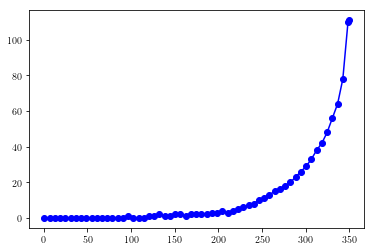

In [41]:
f = 'liqcrys_K0_ovp_other.e'
fanalyzer = ExodusAnalyzer(filename = f)
ts, rvals = fanalyzer.Roughness(numeta = 0)
plt.plot(ts, rvals, '-bo')

In [44]:
ts
rvals

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 2.0,
 2.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 3.0,
 3.0,
 4.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 10.0,
 11.0,
 13.0,
 15.0,
 16.0,
 18.0,
 20.0,
 23.0,
 26.0,
 29.0,
 33.0,
 38.0,
 42.0,
 48.0,
 56.0,
 64.0,
 78.0,
 110.0,
 111.0]

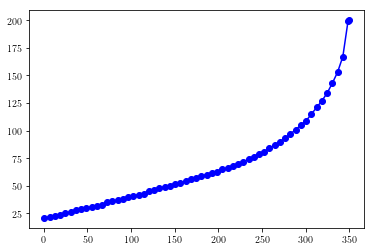

In [39]:
f = 'liqcrys_K0_ovp_other.e'
fanalyzer = ExodusAnalyzer(filename = f)
ts, xvals = fanalyzer.Xvst(numeta = 0)
plt.plot(ts, xvals, '-bo')

In [48]:
f = 'liqcrys_Kp_p_1.0E+01_c_1.0E+00_other.e'
fanalyzer = ExodusAnalyzer(filename = f)
ts, rvals = fanalyzer.Roughness(numeta = 2)
ts, xvals = fanalyzer.Xvst(numeta = 2)
xvals

[21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 41.0,
 42.0,
 43.0,
 44.0,
 46.0,
 47.0,
 48.0,
 50.0,
 51.0,
 52.0,
 54.0,
 55.0,
 56.0,
 58.0,
 59.0,
 60.0,
 62.0,
 63.0,
 65.0,
 66.0,
 68.0,
 69.0,
 71.0,
 72.0,
 74.0,
 75.0,
 77.0,
 79.0,
 80.0,
 82.0,
 84.0,
 85.0,
 87.0,
 89.0,
 91.0,
 93.0,
 95.0,
 97.0,
 99.0,
 101.0,
 103.0,
 105.0,
 108.0,
 110.0,
 113.0,
 115.0,
 118.0,
 121.0,
 124.0,
 128.0,
 132.0,
 136.0,
 143.0,
 151.0,
 170.0]

In [50]:
ts

[0.6000000000000003,
 6.599999999999904,
 12.599999999999776,
 18.600000000000108,
 24.600000000001046,
 30.600000000001984,
 36.60000000000129,
 42.600000000000094,
 48.5999999999989,
 54.599999999997706,
 60.59999999999651,
 66.59999999999717,
 72.60000000000024,
 78.6000000000033,
 84.60000000000637,
 90.60000000000944,
 96.60000000001251,
 102.60000000001558,
 108.60000000001865,
 114.60000000002172,
 120.60000000002479,
 126.60000000002786,
 132.60000000002438,
 138.60000000001892,
 144.60000000001347,
 150.600000000008,
 156.60000000000255,
 162.5999999999971,
 168.59999999999164,
 174.59999999998618,
 180.59999999998072,
 186.59999999997527,
 192.5999999999698,
 198.59999999996435,
 204.5999999999589,
 210.59999999995344,
 216.59999999994798,
 222.59999999994253,
 228.59999999993707,
 234.5999999999316,
 240.59999999992615,
 246.5999999999207,
 252.59999999991524,
 258.5999999999098,
 264.59999999990436,
 270.5999999998989,
 276.59999999989344,
 282.599999999888,
 288.5999999998

In [12]:
f = 'liqcrys_K0_ovp_other.e'
fanalyzer0 = ExodusAnalyzer(filename = f)
AratiosvsX0, ArcratiosvsX0 = fanalyzer0.AreaArcRatiovsX(Xi = 20, Xfs = np.arange(40, 190, 10), ymin = 0, ymax = 201, numeta=0)

arc_length0 = 200.0


In [13]:
ArcratiosvsX0

[1.0,
 1.0538477631085024,
 1.0745584412271572,
 1.1221930009000631,
 1.1676907656649087,
 1.2646365902454164,
 1.3994050093511934,
 1.5502919227461645,
 1.700950800676068,
 1.8446864110969248,
 2.0092918278805616,
 2.162575177241069,
 2.323225641765152,
 2.4838167911774813,
 2.6315635048587156]

In [21]:
f = 'liqcrys_Kp_p_1.0E+01_c_1.0E+00_other.e'
fanalyzer = ExodusAnalyzer(filename = f)
AratiosvsX, ArcratiosvsX = fanalyzer.AreaArcRatiovsX(Xi = 20, Xfs = np.arange(40, 190, 10), ymin = 0, ymax = 201, numeta=2)

arc_length0 = 200.0


In [22]:
ArcratiosvsX

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0082842712474618,
 1.0289949493661166,
 1.0476345596729062,
 1.0745584412271572,
 1.0869848480983502,
 1.1179522746320396,
 1.149864663196856,
 1.1986092239790829,
 1.249573267141982]

In [63]:
f = 'liqcrys_K0_ovp_other.e'
fanalyzer = ExodusAnalyzer(filename = f)
t, t_whole, t_exact = fanalyzer.TimeTransf(tstart = 400, Xval = 150, numeta = 0)
#aratiosvsX = fanalyzer.AreaRatiovsX(Xvals = np.arange(30, 190, 10), Xi = 20, numeta = 0, ymin = 0, ymax = 201)
#arcratiosvsX = fanalyzer.ArcRatiovsX(Xvals = np.arange(30, 190, 10), numeta = 0, ymin = 0, ymax = 201)
AratiosvsX, ArcratiosvsX = fanalyzer.AreaArcRatiovsX(Xi = 20, Xfs = np.arange(30, 190, 10), ymin = 0, ymax = 201, numeta=0)

['e' 't' 'a' -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- --]
nsteps=594

Phase transf at: 558
['e' 't' 'a' -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- --]
nsteps=594

Phase transf at: 85
['e' 't' 'a' -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- --]
nsteps=594

Phase transf at: 168
['e' 't' 'a' -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- --]
nsteps=594

Phase transf at: 242
['e' 't' 'a' -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- --]
nsteps=594

Phase transf at: 313
['e' 't' 'a' -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- --]
nsteps=594

Phase transf at: 373
['e' 't' 'a' -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- --]
nsteps=594

Phase transf at: 418
['e' 't' 'a' -- -- -- -- -- -- -- -

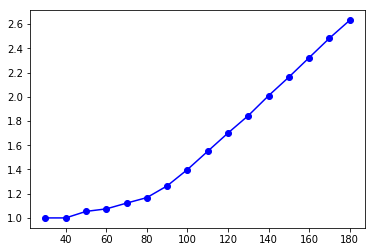

In [64]:

plt.plot(np.arange(30, 190, 10), ArcratiosvsX, '-bo')

In [65]:
f = 'liqcrys_Kp_p_1.0E+01_c_1.0E+00_other.e'
fanalyzer = ExodusAnalyzer(filename = f)
t, t_whole, t_exact = fanalyzer.TimeTransf(tstart = 400, Xval = 150, numeta = 2)
#aratiosvsX = fanalyzer.AreaRatiovsX(Xvals = np.arange(30, 190, 10), Xi = 20, numeta = 0, ymin = 0, ymax = 201)
#arcratiosvsX = fanalyzer.ArcRatiovsX(Xvals = np.arange(30, 190, 10), numeta = 0, ymin = 0, ymax = 201)
AratiosvsX1, ArcratiosvsX1 = fanalyzer.AreaArcRatiovsX(Xi = 20, Xfs = np.arange(30, 190, 10), ymin = 0, ymax = 201, numeta=2)

['e' 't' 'a' -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- --]
nsteps=715

Phase transf at: 700
['e' 't' 'a' -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- --]
nsteps=715

Phase transf at: 86
['e' 't' 'a' -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- --]
nsteps=715

Phase transf at: 169
['e' 't' 'a' -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- --]
nsteps=715

Phase transf at: 247
['e' 't' 'a' -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- --]
nsteps=715

Phase transf at: 321
['e' 't' 'a' -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- --]
nsteps=715

Phase transf at: 389
['e' 't' 'a' -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- --]
nsteps=715

Phase transf at: 452
['e' 't' 'a' -- -- -- -- -- -- -- -

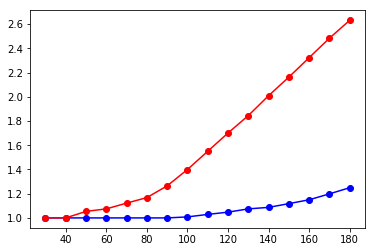

In [67]:
plt.plot(np.arange(30, 190, 10), ArcratiosvsX1, '-bo')
plt.plot(np.arange(30, 190, 10), ArcratiosvsX, '-ro')

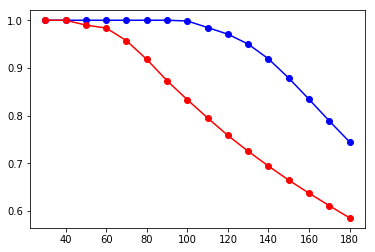

In [48]:
plt.plot(np.arange(30, 190, 10), AratiosvsX1, '-bo')
plt.plot(np.arange(30, 190, 10), AratiosvsX, '-ro')

In [12]:
    times = []
    ps = []
    cs = []
    aratios = []
    aratiosvsX = []
    arcratios = []
    arcratiosvsX = []
f = 'liqcrys_K0_ovp_other.e'
print(f)
                                                                                                              
#ps.append(float(f[13:20]))
#cs.append(float(f[23:30]))
fanalyzer = ExodusAnalyzer(filename = f)

t, t_whole, t_exact = fanalyzer.TimeTransf(tstart = 400, Xval = 150, numeta = 0)
print(t_exact)
print(fanalyzer.AreaRatio(Xi = 20, Xf = 120, numeta = 0, ymin = 0, ymax = 201))
print(fanalyzer.ArcRatio(Xf = 120, numeta = 0, ymin = 0, ymax = 201))
AratiosvsX, ArcratiosvsX = fanalyzer.AreaArcRatiovsX(Xi = 20, Xfs = np.arange(30, 190, 10), ymin = 0, ymax = 201, numeta=0)
print(AratiosvsX)
print(ArcratiosvsX)

liqcrys_K0_ovp_other.e
['e' 't' 'a' -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- --]
nsteps=594

Phase transf at: 558
334.8636505191132
['e' 't' 'a' -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- --]
nsteps=594

Phase transf at: 520
area_act = 15165.5
area_smooth = 20000.0
0.758275
['e' 't' 'a' -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- --]
nsteps=594

Phase transf at: 520
1.700950800676068
['e' 't' 'a' -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- --]
nsteps=594

Phase transf at: 85
['e' 't' 'a' -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- --]
nsteps=594

Phase transf at: 168
['e' 't' 'a' -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- --]
nsteps=594

Phase transf at: 242
['e' 't' 'a' -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 

arc_length0 = 200.0
['e' 't' 'a' -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- --]
Phase transf at: 85
arc length act = 200.0
['e' 't' 'a' -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- --]
Phase transf at: 168
arc length act = 200.0
['e' 't' 'a' -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- --]
Phase transf at: 242
arc length act = 210.769552622
['e' 't' 'a' -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- --]
Phase transf at: 313
arc length act = 214.911688245
['e' 't' 'a' -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- --]
Phase transf at: 373
arc length act = 224.43860018
['e' 't' 'a' -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- --]
Phase transf at: 418
arc length act = 233.538153133
['e' 't' 'a' -- -- -- -- -- -- -- -- -- -- -- -- -- -- -

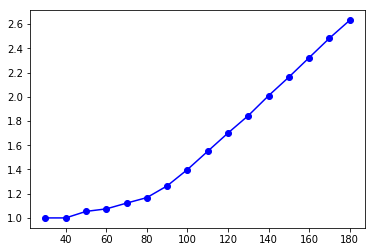

In [51]:
f = 'liqcrys_K0_ovp_other.e'
fanalyzer = ExodusAnalyzer(filename = f)
AratiosvsX, ArcratiosvsX = fanalyzer.AreaArcRatiovsX(Xi = 20, Xfs = np.arange(30, 190, 10), ymin = 0, ymax = 201, numeta=0)
plt.plot( np.arange(30, 190, 10), ArcratiosvsX, '-bo' )

arc_length0 = 222.77531748844217
[0.3283333333333333, 0.396875, 0.4288, 0.45066666666666666, 0.4644285714285714, 0.4775625, 0.4886111111111111, 0.49955, 0.5112727272727273, 0.5240833333333333, 0.5333076923076923, 0.5383571428571429, 0.5381333333333334, 0.536625]
[1.001888189451118, 1.0352381734978167, 1.068588157544515, 1.1129761262453626, 1.1610237539905721, 1.212759836679354, 1.2734326926108146, 1.3337285896090028, 1.399393741425623, 1.4763811563168903, 1.5663881473349248, 1.6561710400026077, 1.7604326220295703, 1.8685094317243076]


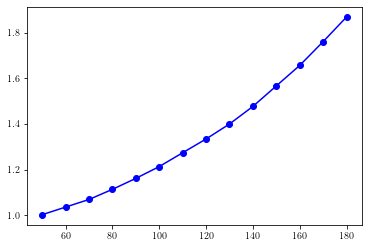

In [42]:
f='nucl/lcn_Kp_p_1.0E+01_c_1.0E+00_other_alpha0.e'
fanalyzer = ExodusAnalyzer(filename = f)
AratiosvsX, ArcratiosvsX = fanalyzer.AreaArcRatiovsX(Xi = 20, Xfs = np.arange(50, 190, 10), ymin = 0, ymax = 201, numeta=2)
print(AratiosvsX)
print(ArcratiosvsX)
plt.plot(np.arange(50, 190, 10), ArcratiosvsX, '-bo')

arc_length0 = 222.77531748844217
[0.32866666666666666, 0.398875, 0.431, 0.4543333333333333, 0.4690714285714286, 0.4813125, 0.49294444444444446, 0.50425, 0.5163636363636364, 0.5302083333333333, 0.5386923076923077, 0.5415357142857142, 0.5423666666666667, 0.54078125]
[1.001888189451118, 1.0352381734978167, 1.068588157544515, 1.1129761262453626, 1.157305087425147, 1.212759836679354, 1.2697730335664523, 1.337628752443034, 1.399572468862952, 1.477303404193765, 1.5609481210608989, 1.6606707398431853, 1.7654094472095214, 1.8777183189596365]


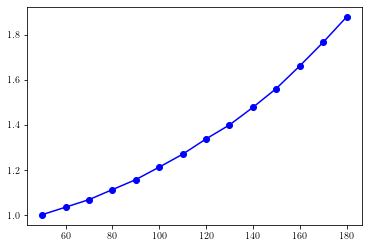

In [41]:
f1='nucl/lcn_Kp_p_1.0E+01_c_1.0E+00_other_alpha1.e'
fanalyzer1 = ExodusAnalyzer(filename = f1)
AratiosvsX1, ArcratiosvsX1 = fanalyzer1.AreaArcRatiovsX(Xi = 20, Xfs = np.arange(50, 190, 10), ymin = 0, ymax = 201, numeta=2)
print(AratiosvsX1)
print(ArcratiosvsX1)
plt.plot(np.arange(50, 190, 10), ArcratiosvsX1, '-bo')

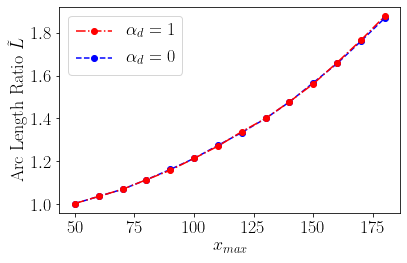

In [86]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 18
rcParams['font.serif'] = ['Computer Modern Roman']
rcParams['text.usetex'] = True
rcParams["font.weight"] = "bold"
rcParams["axes.labelweight"] = "bold"

plt.plot(np.arange(50, 190, 10), ArcratiosvsX, '--bo',label=r'$\alpha_d=0$')
plt.plot(np.arange(50, 190, 10), ArcratiosvsX1, '-.ro',label=r'$\alpha_d=1$')
plt.xlabel(r'$x_{max}$')
plt.ylabel(r'Arc Length Ratio $\tilde{L}$')
#plt.show()
handles,labels = plt.gca().get_legend_handles_labels()
order=[1,0]

plt.legend(handles,labels,loc=2)

#plt.legend({r'$\alpha_d=0$',r'$\alpha_d=1$'})
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.tight_layout()
plt.savefig('nucl_01_compare.pdf')

arc_length0 = 223.799309729
[0.27466666666666667, 0.32725, 0.3449, 0.3471666666666667, 0.3434285714285714, 0.336375, 0.3305, 0.32365, 0.3170454545454545, 0.31025, 0.30303846153846153, 0.29678571428571426, 0.2894, 0.2811875]
[1.049245946724374, 1.11474029011966, 1.1774446806010186, 1.239777393613724, 1.3185125470538837, 1.3966087764438748, 1.4735640765732747, 1.5392048699611562, 1.62195266405949, 1.6985795168116202, 1.7800529118616706, 1.8671969407612443, 1.9463082644989342, 2.027924885934925]


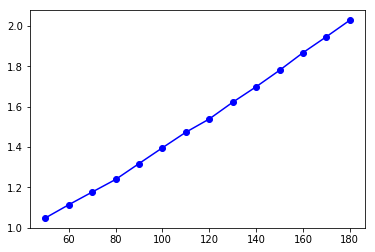

In [32]:
f0='nucl/lcn0_other.e'
fanalyzer0 = ExodusAnalyzer(filename = f0)
AratiosvsX0, ArcratiosvsX0 = fanalyzer0.AreaArcRatiovsX(Xi = 20, Xfs = np.arange(50, 190, 10), ymin = 0, ymax = 201, numeta=0)
print(AratiosvsX0)
print(ArcratiosvsX0)
plt.plot(np.arange(50, 190, 10), ArcratiosvsX0, '-bo')

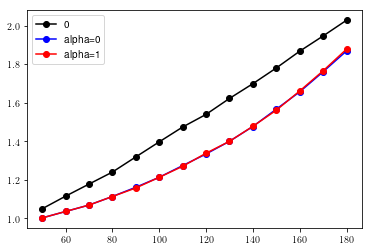

In [45]:
plt.plot(np.arange(50, 190, 10), ArcratiosvsX0, '-ko')
plt.plot(np.arange(50, 190, 10), ArcratiosvsX, '-bo')
plt.plot(np.arange(50, 190, 10), ArcratiosvsX1, '-ro')
plt.legend({'0','alpha=0','alpha=1'})

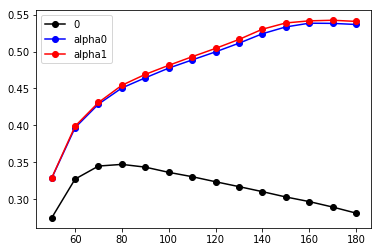

In [38]:
plt.plot(np.arange(50, 190, 10), AratiosvsX0, '-ko')
plt.plot(np.arange(50, 190, 10), AratiosvsX, '-bo')
plt.plot(np.arange(50, 190, 10), AratiosvsX1, '-ro')
plt.legend({'0','alpha0','alpha1'})

In [51]:
AratiosvsX0

[0.27466666666666667,
 0.32725,
 0.3449,
 0.3471666666666667,
 0.3434285714285714,
 0.336375,
 0.3305,
 0.32365,
 0.3170454545454545,
 0.31025,
 0.30303846153846153,
 0.29678571428571426,
 0.2894,
 0.2811875]

In [12]:
np.arange(30,190,10)

array([ 30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150,
       160, 170, 180])

[0.0, 0.0, 1.0, 2.0, 5.0, 10.0, 16.0, 22.0, 29.0, 37.0, 45.0, 53.0, 62.0, 71.0, 81.0, 91.0]


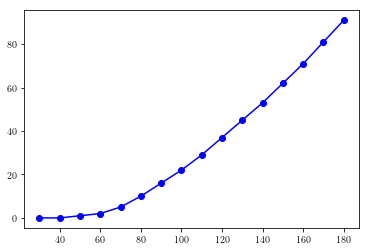

In [11]:
f = 'liqcrys_K0_ovp_other.e'
fanalyzer = ExodusAnalyzer(filename = f)
rvals = fanalyzer.RoughnessvsX(Xi=20, Xfs=np.arange(30,190,10), numeta = 0)
print(rvals)
plt.plot(np.arange(30,190,10), rvals, '-bo')

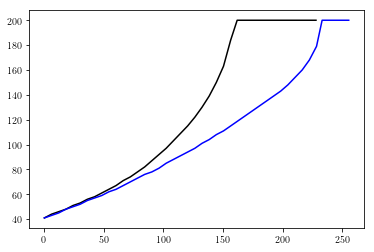

In [14]:
f = 'nucl/lcn0_other.e'
fanalyzer = ExodusAnalyzer(filename = f)
txs, xvals = fanalyzer.Xvst(numeta = 0)

f1 = 'nucl/lcn_Kp_p_1.0E+01_c_1.0E+00_other_alpha0.e'
fanalyzer1 = ExodusAnalyzer(filename = f1)
txs1, xvals1 = fanalyzer1.Xvst(numeta = 2)
plt.plot(txs, xvals, '-k')
plt.plot(txs1, xvals1, '-b')
spio.savemat('nucl_Xvst',{'txs':txs, 'txs1': txs1, 'xvals':xvals, 'xvals1':xvals1})

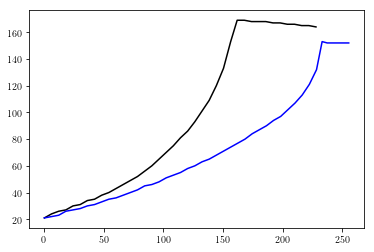

In [15]:
f = 'nucl/lcn0_other.e'
fanalyzer = ExodusAnalyzer(filename = f)
trs, rvals = fanalyzer.Roughness(numeta = 0)

f1 = 'nucl/lcn_Kp_p_1.0E+01_c_1.0E+00_other_alpha0.e'
fanalyzer1 = ExodusAnalyzer(filename = f1)
trs1, rvals1 = fanalyzer1.Roughness(numeta = 2)
plt.plot(trs, rvals, '-k')
plt.plot(trs1, rvals1, '-b')
spio.savemat('nucl_roughness',{'trs':trs, 'trs1': trs1, 'rvals':rvals, 'rvals1': rvals1})

arc_length0 = 223.799309729
arc_length0 = 222.775317488


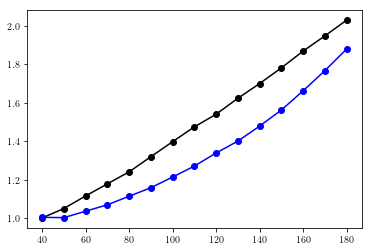

In [17]:
f0 = 'nucl/lcn0_other.e'
Xfvals = np.arange(40, 190, 10)
fanalyzer0 = ExodusAnalyzer(filename = f0)
AratiosvsX0, ArcratiosvsX0 = fanalyzer0.AreaArcRatiovsX(Xi = 20, Xfs = Xfvals, ymin = 0, ymax = 201, numeta=0)
plt.plot(Xfvals, ArcratiosvsX0, '-ko')

f101='nucl/lcn_Kp_p_1.0E+01_c_1.0E+00_other_alpha1.e'
fanalyzer101 = ExodusAnalyzer(filename = f101)
AratiosvsX101, ArcratiosvsX101 = fanalyzer101.AreaArcRatiovsX(Xi = 20, Xfs = Xfvals, ymin = 0, ymax = 201, numeta=2)
plt.plot(Xfvals, ArcratiosvsX101, '-bo')
spio.savemat('nucl_AreaArc',{'Xs':Xfvals, 'ArcratiosvsX0': ArcratiosvsX0, 'ArcratiosvsX101':ArcratiosvsX101, 'AratiosvsX0': AratiosvsX0, 'AratiosvsX101':AratiosvsX101})

In [14]:
f = 'liqcrys_K0_ovp_other.e'
fanalyzer = ExodusAnalyzer(filename = f)
fanalyzer.TimeTransf(tstart = 100, Xval = 130, numeta = 0)

(535, 321.39499999985253, 321.2976957670202)

In [40]:
f = 'liqcrys_Kp_p_1.0E+01_c_1.0E+00_other.e'
fanalyzer = ExodusAnalyzer(filename = f)
fanalyzer.TimeTransf(tstart = 100, Xval = 130, numeta = 2)

(668, 401.1149999997802, 400.5855862233422)

In [16]:
fanalyzer = ExodusAnalyzer(filename = f)
fanalyzer.TimeTransf(tstart = 100, Xval = 130, numeta = 0)

(221, 133.04523437502397, 132.57440461920717)

G ?�    ?�������?�������?�   
max at t1=0.642604556506



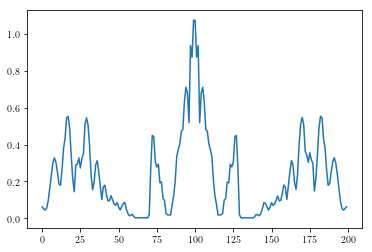

In [169]:
f = 'nucl/lcn0_other.e'
fanalyzer = ExodusAnalyzer(filename = f)
vv = fanalyzer.MaxValvsY(numvar=0, t=100, ymin = 0, ymax = 201)  
plt.plot(vv)
spio.savemat('nucl0_currdens.mat',{'G':vv})

b'G\x01F?\xf0\x01F?\xef\xff\xff\xff\xff\xf0\xcc?\xef\xff\xff\xff\xff\xf0\xcc?\xf0'
max at t1=0.904838585911145

b'G\x1c?\xf0\x1c?\xef\xff\xff\xff\xff\xfe\xba?\xef\xff\xff\xff\xff\xfe\xb8?\xf0'
max at t1=0.7989013447120906



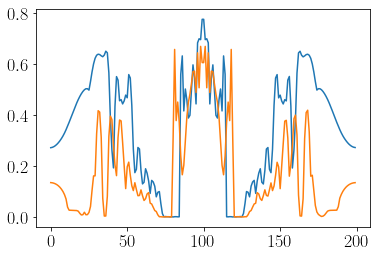

In [11]:
f = 'nucl/lcn0_r5_other.e'
fanalyzer = ExodusAnalyzer(filename = f)
vv = fanalyzer.MaxValvsY(numvar=0, t=100, ymin = 0, ymax = 201)  
plt.plot(vv)
spio.savemat('nucl0_currdens_r5.mat',{'G':vv})

f = 'nucl/lcn0_r10_other.e'
fanalyzer = ExodusAnalyzer(filename = f)
vv = fanalyzer.MaxValvsY(numvar=0, t=100, ymin = 0, ymax = 201)  
plt.plot(vv)
spio.savemat('nucl0_currdens_r10.mat',{'G':vv})

currdens ��O��-<庬'�D콅и����
max at t1=0.872601229324



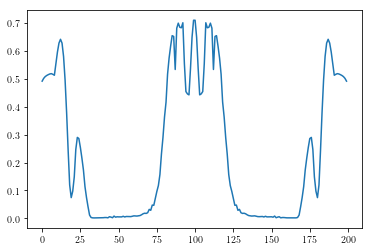

In [170]:
 f = 'nucl/lcn_Kp_p_1.0E+01_c_1.0E+00_other_alpha0.e'
fanalyzer = ExodusAnalyzer(filename = f)
vv = fanalyzer.MaxValvsY(numvar=4, t=100, ymin = 0, ymax = 201)  
plt.plot(vv)
spio.savemat('nucl101_currdens.mat',{'G':vv})

b'currdens\xe4\xec\xfb\xfa}R\xf2<\xe4\xbb\xe9\xd3\x0e\xc8\x8c\xbd\x81\x86O\xb7B\xafM\xbd'
max at t1=1.8453365968823257

b'currdens\xe5\xb04$\xf4\xe1Z<\xe4\xf0\x9ei\x06\x8f\xaf\xbd\x81\x9fp 4I\xda\xbd'
max at t1=1.2813667420584545



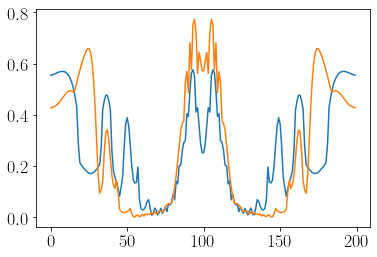

In [12]:
#Different radii
f = 'nucl/lcn_Kp_p_1.0E+01_c_1.0E+00_r5_other.e'
fanalyzer = ExodusAnalyzer(filename = f)
vv = fanalyzer.MaxValvsY(numvar=4, t=100, ymin = 0, ymax = 201)  
plt.plot(vv)
spio.savemat('nucl101_currdens_r5.mat',{'G':vv})

f = 'nucl/lcn_Kp_p_1.0E+01_c_1.0E+00_r10_other.e'
fanalyzer = ExodusAnalyzer(filename = f)
vv = fanalyzer.MaxValvsY(numvar=4, t=100, ymin = 0, ymax = 201)  
plt.plot(vv)
spio.savemat('nucl101_currdens_r10.mat',{'G':vv})

arc_length0 = 200.0
arc_length0 = 200.0


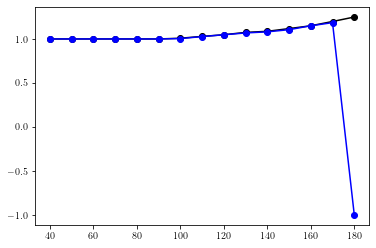

In [7]:
f0 = 'liqcrys_Kp_p_1.0E+01_c_1.0E+00_other.e'
Xfvals = np.arange(40, 190, 10)
fanalyzer0 = ExodusAnalyzer(filename = f0)
AratiosvsX0, ArcratiosvsX0 = fanalyzer0.AreaArcRatiovsX(Xi = 20, Xfs = Xfvals, ymin = 0, ymax = 201, numeta=2)
plt.plot(Xfvals, ArcratiosvsX0, '-ko')

f101='alpha1/lc10_1_testMat_alphad1_other.e'
fanalyzer101 = ExodusAnalyzer(filename = f101)
AratiosvsX101, ArcratiosvsX101 = fanalyzer101.AreaArcRatiovsX(Xi = 20, Xfs = Xfvals, ymin = 0, ymax = 201, numeta=2)
plt.plot(Xfvals, ArcratiosvsX101, '-bo')


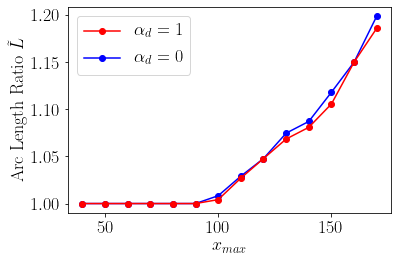

In [15]:
plt.plot(np.arange(40, 180, 10), ArcratiosvsX0[:-1], '-bo',label=r'$\alpha_d=0$')
plt.plot(np.arange(40, 180, 10), ArcratiosvsX101[:-1], '-ro',label=r'$\alpha_d=1$')
plt.xlabel(r'$x_{max}$')
plt.ylabel(r'Arc Length Ratio $\tilde{L}$')
#plt.show()
handles,labels = plt.gca().get_legend_handles_labels()
order=[1,0]

plt.legend(handles,labels,loc=2)

#plt.legend({r'$\alpha_d=0$',r'$\alpha_d=1$'})
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.tight_layout()
plt.savefig('alpha_01_compare.pdf')

arc_length0 = 223.79930972903315
arc_length0 = 222.77531748844217


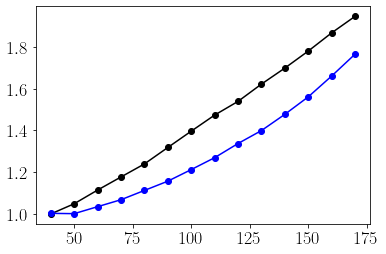

In [7]:
f0 = 'nucl/lcn0_other.e'
Xfvals = np.arange(40, 180, 10)
fanalyzer0 = ExodusAnalyzer(filename = f0)
AratiosvsX0, ArcratiosvsX0 = fanalyzer0.AreaArcRatiovsX(Xi = 20, Xfs = Xfvals, ymin = 0, ymax = 201, numeta=0)
plt.plot(Xfvals, ArcratiosvsX0, '-ko')

f101='nucl/lcn_Kp_p_1.0E+01_c_1.0E+00_other_alpha1.e'
fanalyzer101 = ExodusAnalyzer(filename = f101)
AratiosvsX101, ArcratiosvsX101 = fanalyzer101.AreaArcRatiovsX(Xi = 20, Xfs = Xfvals, ymin = 0, ymax = 201, numeta=2)
plt.plot(Xfvals, ArcratiosvsX101, '-bo')
#spio.savemat('nucl_AreaArc',{'Xs':Xfvals, 'ArcratiosvsX0': ArcratiosvsX0, 'ArcratiosvsX101':ArcratiosvsX101, 'AratiosvsX0': AratiosvsX0, 'AratiosvsX101':AratiosvsX101})


arc_length0 = 205.78584445398434
arc_length0 = 204.97056274847716


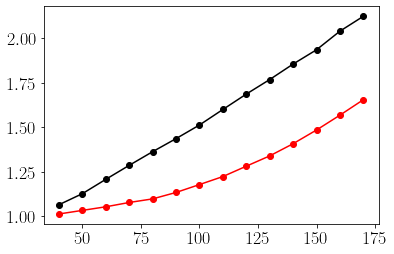

In [5]:
f0_r5 = 'nucl/lcn0_r5_other.e'
Xfvals = np.arange(40, 180, 10)
fanalyzer0_r5 = ExodusAnalyzer(filename = f0_r5)
AratiosvsX0_r5, ArcratiosvsX0_r5 = fanalyzer0_r5.AreaArcRatiovsX(Xi = 20, Xfs = Xfvals, ymin = 0, ymax = 201, numeta=0)
plt.plot(Xfvals, ArcratiosvsX0_r5, '-ko')

f101_r5='nucl/lcn_Kp_p_1.0E+01_c_1.0E+00_r5_other.e'
fanalyzer101_r5 = ExodusAnalyzer(filename = f101_r5)
AratiosvsX101_r5, ArcratiosvsX101_r5 = fanalyzer101_r5.AreaArcRatiovsX(Xi = 20, Xfs = Xfvals, ymin = 0, ymax = 201, numeta=2)
plt.plot(Xfvals, ArcratiosvsX101_r5, '-ro')

arc_length0 = 211.76725402381348
arc_length0 = 210.9519723183063


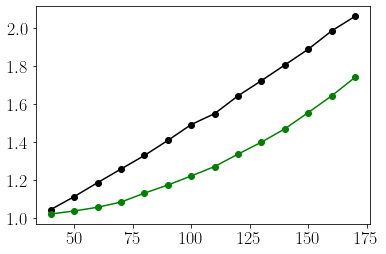

In [6]:
f0_r10 = 'nucl/lcn0_r10_other.e'
Xfvals = np.arange(40, 180, 10)
fanalyzer0_r10 = ExodusAnalyzer(filename = f0_r10)
AratiosvsX0_r10, ArcratiosvsX0_r10 = fanalyzer0_r10.AreaArcRatiovsX(Xi = 20, Xfs = Xfvals, ymin = 0, ymax = 201, numeta=0)
plt.plot(Xfvals, ArcratiosvsX0_r10, '-ko')

f101_r10='nucl/lcn_Kp_p_1.0E+01_c_1.0E+00_r10_other.e'
fanalyzer101_r10 = ExodusAnalyzer(filename = f101_r10)
AratiosvsX101_r10, ArcratiosvsX101_r10 = fanalyzer101_r10.AreaArcRatiovsX(Xi = 20, Xfs = Xfvals, ymin = 0, ymax = 201, numeta=2)
plt.plot(Xfvals, ArcratiosvsX101_r10, '-go')

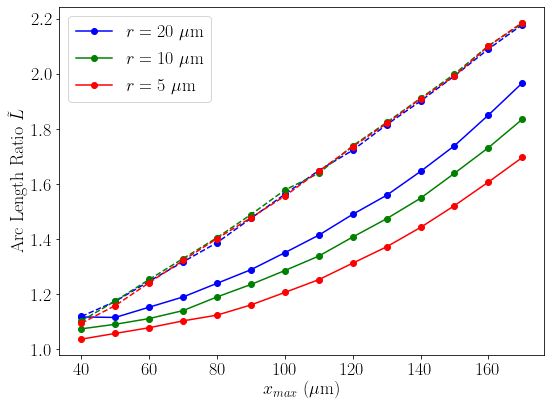

In [38]:
import matplotlib
matplotlib.rc('figure', figsize=[8,6])

plt.plot(Xfvals, 222.77531748844217/200.0 * np.array(ArcratiosvsX101), '-bo', label='$r=20$ $\mu$m')
plt.plot(Xfvals, 210.9519723183063/ 200.0 * np.array(ArcratiosvsX101_r10), '-go', label='$r=10$ $\mu$m')
plt.plot(Xfvals, 204.97056274847716/200.0 * np.array(ArcratiosvsX101_r5), '-ro', label = '$r=5$ $\mu$m')

#plt.legend({'r20','r5','r10'})

plt.plot(Xfvals, 223.79930972903315/200.0 * np.array(ArcratiosvsX0), '--bo')
plt.plot(Xfvals, 211.76725402381348/ 200.0 * np.array(ArcratiosvsX0_r10), '--go')
plt.plot(Xfvals, 205.78584445398434/200.0 * np.array(ArcratiosvsX0_r5), '--ro')

plt.xlabel(r'$x_{max}$ ($\mu$m)')
plt.ylabel(r'Arc Length Ratio $\tilde{L}$')

handles,labels = plt.gca().get_legend_handles_labels()
order=[0,1,2]

plt.legend(handles,labels,loc=2)

#plt.legend({r'$\alpha_d=0$',r'$\alpha_d=1$'})
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.tight_layout()

plt.savefig('nucl_r.pdf')

In [30]:
spio.savemat('nucl_r.mat',{'Xs':Xfvals, 'ArcratiosvsX0': ArcratiosvsX0, 'ArcratiosvsX0_r5': ArcratiosvsX0_r5, 'ArcratiosvsX0_r10': ArcratiosvsX0_r10, 'ArcratiosvsX101':ArcratiosvsX101, 'AratiosvsX0': AratiosvsX0, 'AratiosvsX101':AratiosvsX101, 'ArcratiosvsX101_r5':ArcratiosvsX101_r5, 'ArcratiosvsX101_r10':ArcratiosvsX101_r10, 'AratiosvsX101_r5':AratiosvsX101_r5, 'AratiosvsX101_r10':AratiosvsX101_r10})


In [75]:
f0 = 'nucl/lcn0_other.e'
f101='nucl/lcn_Kp_p_1.0E+01_c_1.0E+00_other_alpha1.e'
f0_r5 = 'nucl/lcn0_r5_other.e'
f101_r5='nucl/lcn_Kp_p_1.0E+01_c_1.0E+00_r5_other.e'
f0_r10 = 'nucl/lcn0_r10_other.e'
f101_r10='nucl/lcn_Kp_p_1.0E+01_c_1.0E+00_r10_other.e'

fanalyzer0 = ExodusAnalyzer(filename = f0)
fanalyzer0_r5 = ExodusAnalyzer(filename = f0_r5)
fanalyzer0_r10 = ExodusAnalyzer(filename = f0_r10)
fanalyzer101_r5 = ExodusAnalyzer(filename = f101_r5)
fanalyzer101_r10 = ExodusAnalyzer(filename = f101_r10)
fanalyzer101 = ExodusAnalyzer(filename = f101)

In [50]:
txs0, xvals0 = fanalyzer0.Xvst(numeta = 0)
txs0_r5, xvals0_r5 = fanalyzer0_r5.Xvst(numeta = 0)
txs0_r10, xvals0_r10 = fanalyzer0_r10.Xvst(numeta = 0)
txs101, xvals101 = fanalyzer101.Xvst(numeta = 2)
txs101_r5, xvals101_r5 = fanalyzer101_r5.Xvst(numeta = 2)
txs101_r10, xvals101_r10 = fanalyzer101_r10.Xvst(numeta = 2)

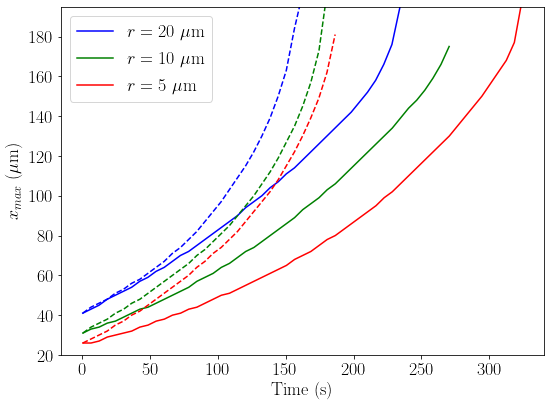

In [67]:
import matplotlib
matplotlib.rc('figure', figsize=[8,6])

from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 18
rcParams['font.serif'] = ['Computer Modern Roman']
rcParams['text.usetex'] = True
rcParams["font.weight"] = "bold"
rcParams["axes.labelweight"] = "bold"

plt.plot(txs101, xvals101, '-b', label = r'$r=20$ $\mu$m')
plt.plot(txs101_r10, xvals101_r10, '-g', label = r'$r=10$ $\mu$m')
plt.plot(txs101_r5, xvals101_r5, '-r', label = r'$r=5$ $\mu$m')

plt.plot(txs0, xvals0, '--b', label = r'$r=20$ $\mu$m')
plt.plot(txs0_r10, xvals0_r10, '--g', label = r'$r=10$ $\mu$m')
plt.plot(txs0_r5, xvals0_r5, '--r', label=r'$r=5$ $\mu$m')

plt.ylabel(r'$x_{max}$ ($\mu$m)')
plt.xlabel(r'Time (s)')
plt.ylim([20, 195])

handles,labels = plt.gca().get_legend_handles_labels()
order=[0,1,2]
plt.legend(handles,labels,loc=2)

#plt.legend({r'$\alpha_d=0$',r'$\alpha_d=1$'})
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.tight_layout()

plt.savefig('nucl_r_Xvst.pdf')

In [82]:
#Roughness for nucl r values
Xfvals = np.arange(40, 180, 10)

rf0 = fanalyzer0.RoughnessvsX(Xfs=Xfvals, numeta = 0)
rf0_r10 = fanalyzer0_r10.RoughnessvsX(Xfs=Xfvals, numeta = 0)
rf0_r5 = fanalyzer0_r5.RoughnessvsX(Xfs=Xfvals, numeta = 0)

rf101 = fanalyzer101.RoughnessvsX(Xfs=Xfvals, numeta = 2)
rf101_r10 = fanalyzer101_r10.RoughnessvsX(Xfs=Xfvals, numeta = 2)
rf101_r5 = fanalyzer101_r5.RoughnessvsX(Xfs=Xfvals, numeta = 2)

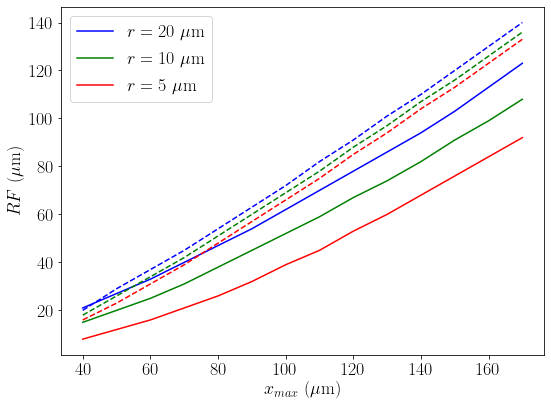

In [83]:
import matplotlib
matplotlib.rc('figure', figsize=[8,6])

from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 18
rcParams['font.serif'] = ['Computer Modern Roman']
rcParams['text.usetex'] = True
rcParams["font.weight"] = "bold"
rcParams["axes.labelweight"] = "bold"

plt.plot(Xfvals, rf101, '-b', label = r'$r=20$ $\mu$m')
plt.plot(Xfvals, rf101_r10, '-g', label = r'$r=10$ $\mu$m')
plt.plot(Xfvals, rf101_r5, '-r', label = r'$r=5$ $\mu$m')

plt.plot(Xfvals, rf0, '--b', label = r'$r=20$ $\mu$m')
plt.plot(Xfvals, rf0_r10, '--g', label = r'$r=10$ $\mu$m')
plt.plot(Xfvals, rf0_r5, '--r', label=r'$r=5$ $\mu$m')

plt.ylabel(r'$RF$ ($\mu$m)')
plt.xlabel(r'$x_{max}$ ($\mu$m)')
#plt.ylim([20, 195])

handles,labels = plt.gca().get_legend_handles_labels()
order=[0,1,2]
plt.legend(handles,labels,loc=2)

#plt.legend({r'$\alpha_d=0$',r'$\alpha_d=1$'})
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.tight_layout()

#plt.savefig('nucl_r_RFvsx.pdf')

In [84]:
txs0, rfvals0 = fanalyzer0.Roughness(numeta = 0)
txs0_r5, rfvals0_r5 = fanalyzer0_r5.Roughness(numeta = 0)
txs0_r10, rfvals0_r10 = fanalyzer0_r10.Roughness(numeta = 0)
txs101, rfvals101 = fanalyzer101.Roughness(numeta = 2)
txs101_r5, rfvals101_r5 = fanalyzer101_r5.Roughness(numeta = 2)
txs101_r10, rfvals101_r10 = fanalyzer101_r10.Roughness(numeta = 2)

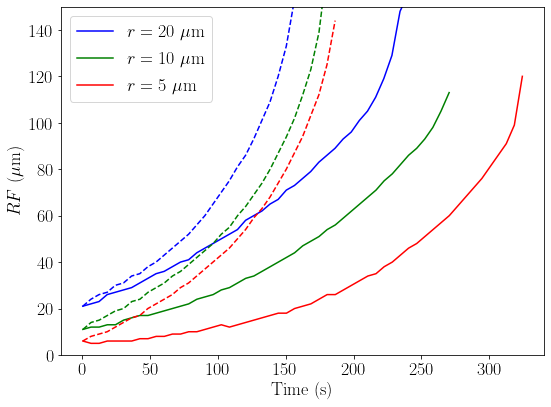

In [89]:
import matplotlib
matplotlib.rc('figure', figsize=[8,6])

from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 18
rcParams['font.serif'] = ['Computer Modern Roman']
rcParams['text.usetex'] = True
rcParams["font.weight"] = "bold"
rcParams["axes.labelweight"] = "bold"

plt.plot(txs101, rfvals101, '-b', label = r'$r=20$ $\mu$m')
plt.plot(txs101_r10, rfvals101_r10, '-g', label = r'$r=10$ $\mu$m')
plt.plot(txs101_r5, rfvals101_r5, '-r', label = r'$r=5$ $\mu$m')

plt.plot(txs0, rfvals0, '--b', label = r'$r=20$ $\mu$m')
plt.plot(txs0_r10, rfvals0_r10, '--g', label = r'$r=10$ $\mu$m')
plt.plot(txs0_r5, rfvals0_r5, '--r', label=r'$r=5$ $\mu$m')

plt.ylabel(r'$RF$ ($\mu$m)')
plt.xlabel(r'Time (s)')
plt.ylim([0, 150])

handles,labels = plt.gca().get_legend_handles_labels()
order=[0,1,2]
plt.legend(handles,labels,loc=2)

#plt.legend({r'$\alpha_d=0$',r'$\alpha_d=1$'})
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.tight_layout()

plt.savefig('nucl_r_RFvst.pdf')

In [9]:
#Roughness for nucl r values
#f0 = 'nucl/lcn0_r5_other.e'
f1= 'nucl/lcn_Kp_p_1.0E+01_c_1.0E+00_r5_other.e'
f4 = 'nucl/lcn_Kp_p_1.0E+01_c_1.0E+00_r5_mv4_other.e'
f3 = 'nucl/lcn_Kp_p_1.0E+01_c_1.0E+00_r5_mv3_other.e'

fanalyzer1 = ExodusAnalyzer(filename = f1)
fanalyzer4 = ExodusAnalyzer(filename = f4)
fanalyzer3 = ExodusAnalyzer(filename = f3)

In [ ]:
Xfvals = np.arange(40, 160, 10)

rf1 = fanalyzer1.RoughnessvsX(Xfs=Xfvals, numeta = 2)
rf4 = fanalyzer4.RoughnessvsX(Xfs=Xfvals, numeta = 2)
rf3 = fanalyzer3.RoughnessvsX(Xfs=Xfvals, numeta = 2)

plt.plot(Xfvals, rf1, '-bo', label = r'$r=20$ $\mu$m')
plt.plot(Xfvals, rf4, '-go', label = r'$r=10$ $\mu$m')
plt.plot(Xfvals, rf3, '-ro', label = r'$r=5$ $\mu$m')

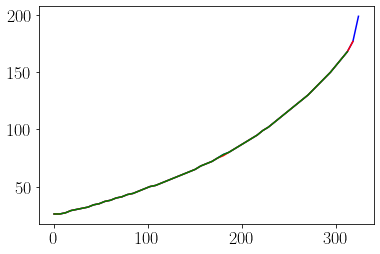

In [10]:
txs1, xvals1 = fanalyzer1.Xvst(numeta = 2)
txs4, xvals4 = fanalyzer4.Xvst(numeta = 2)
txs3, xvals3 = fanalyzer3.Xvst(numeta = 2)

plt.plot(txs1, xvals1, '-b', label = r'$r=20$ $\mu$m')
plt.plot(txs4, xvals4, '-r', label = r'$r=20$ $\mu$m')
plt.plot(txs3, xvals3, '-g', label = r'$r=10$ $\mu$m')

In [4]:
#DiffCs
f1= 'nucl/diffCs/lcn_Kp_p_1.0E+01_c_1.0E+00_r5_mv_other.e'
f3 = 'nucl/diffCs/lcn_Kp_p_1.0E+01_c_1.0E+00_r5_mv3_other.e'

fanalyzer1 = ExodusAnalyzer(filename = f1)
#fanalyzer4 = ExodusAnalyzer(filename = f4)
fanalyzer3 = ExodusAnalyzer(filename = f3)



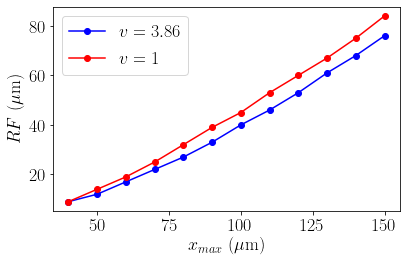

In [20]:
Xfvals = np.arange(40, 160, 10)

rf1 = fanalyzer1.RoughnessvsX(Xfs=Xfvals, numeta = 2)
#rf4 = fanalyzer4.RoughnessvsX(Xfs=Xfvals, numeta = 2)
rf3 = fanalyzer3.RoughnessvsX(Xfs=Xfvals, numeta = 2)

plt.plot(Xfvals, rf1, '-bo', label = r'$v=3.86$')
#plt.plot(Xfvals, rf4, '-go', label = r'$r=10$ $\mu$m')
plt.plot(Xfvals, rf3, '-ro', label = r'$v=1$')

plt.ylabel(r'$RF$ ($\mu$m)')
plt.xlabel(r'$x_{max}~(\mu$m)')
#plt.ylim([0, 150])

handles,labels = plt.gca().get_legend_handles_labels()
order=[0,1]
plt.legend(handles,labels)

#plt.legend({r'$\alpha_d=0$',r'$\alpha_d=1$'})
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.tight_layout()

plt.savefig('nucl_mv_RFvst.pdf')

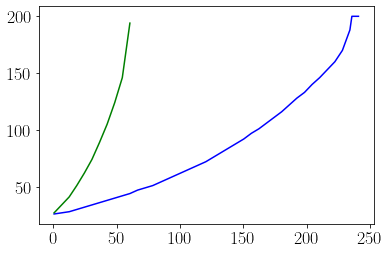

In [8]:
txs1, xvals1 = fanalyzer1.Xvst(numeta = 2)
txs3, xvals3 = fanalyzer3.Xvst(numeta = 2)

plt.plot(txs1, xvals1, '-b', label = r'$v=3.86$')
plt.plot(txs3, xvals3, '-g', label = r'$v=1$')



In [5]:
Xfvals = np.arange(40, 180, 10)
AratiosvsX1, ArcratiosvsX1 = fanalyzer1.AreaArcRatiovsX(Xi = 20, Xfs = Xfvals, ymin = 0, ymax = 201, numeta=2)
AratiosvsX3, ArcratiosvsX3 = fanalyzer3.AreaArcRatiovsX(Xi = 20, Xfs = Xfvals, ymin = 0, ymax = 201, numeta=2)


arc_length0 = 204.97056274847716
arc_length0 = 205.78584445398434


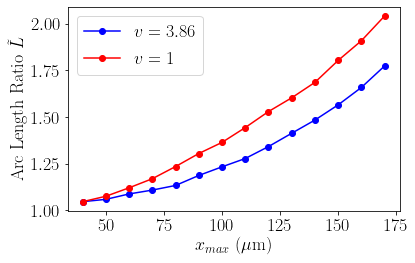

In [7]:
plt.plot(Xfvals, 204.97056274847716/200.0 * np.array(ArcratiosvsX1), '-bo', label = r'$v=3.86$')
plt.plot(Xfvals, 205.78584445398434/ 200.0 * np.array(ArcratiosvsX3), '-ro', label = r'$v=1$')
#plt.plot(Xfvals, 204.97056274847716/200.0 * np.array(ArcratiosvsX101_r5), '-ro', label = '$r=5$ $\mu$m')

plt.xlabel(r'$x_{max}$ ($\mu$m)')
plt.ylabel(r'Arc Length Ratio $\tilde{L}$')

handles,labels = plt.gca().get_legend_handles_labels()
order=[0,1]

plt.legend(handles,labels,loc=2)

#plt.legend({r'$\alpha_d=0$',r'$\alpha_d=1$'})
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.tight_layout()

plt.savefig('nucl_mv_alr.pdf')